In [1]:
data_path = './Wiki-Hades/train.txt'
import json
# parse the json data into a list of dictionaries
data = []
with open(data_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))


In [2]:
masked_data = []
for datapoint in data:
    replaced_sent = datapoint['replaced']
    lower_id = datapoint['replaced_ids'][0]
    upper_id = datapoint['replaced_ids'][1]
    replaced_sent = replaced_sent.split()
    for i in range(lower_id, upper_id+1):
        replaced_sent[i] = '[MASK]'
    masked_sent = ' '.join(replaced_sent)
    masked_data.append({'sentence': masked_sent, 'label': datapoint['hallucination'], 'replaced_ids': datapoint['replaced_ids']})

In [3]:
# # load a bertformaskedlm model
# from transformers import BertForMaskedLM, AutoTokenizer
# import torch
# model = BertForMaskedLM.from_pretrained('bert-base-uncased').to('cuda')
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
# # for each sentence in the masked data, predict the top 20 words that could fill in the mask`sa`

# labeled_multisample_data = []
# counter = 0
# for datapoint in masked_data:
#     input_ids = tokenizer.encode(datapoint['sentence'], return_tensors='pt').to('cuda')
#     mask_id = torch.where(input_ids == tokenizer.mask_token_id)[1].to('cuda')
#     predictions = model(input_ids)[0][:,mask_id,:].topk(10).indices.tolist()[0]
#     sentences = []
#     for i in range(10):
#         sentence = datapoint['sentence'].split()
#         for j in range(len(predictions)):
#             sentence[datapoint['replaced_ids'][0] + j] = tokenizer.decode(predictions[j][i])
#         sentences.append(' '.join(sentence))
#     labeled_multisample_data.append({'original':datapoint['sentence'], 'replaced_ids': datapoint['replaced_ids'],'sentences' : sentences, 'label': datapoint['label']})

#     if counter % 100 == 0:
#         print(counter)
#     counter += 1
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700


In [11]:
# # for each sentence in the masked data, predict the top 20 words that could fill in the mask`sa`

# labeled_multisample_data2 = []
# counter = 0
# for datapoint in masked_data:
#     input_ids = tokenizer.encode(datapoint['sentence'], return_tensors='pt').to('cuda')
#     mask_id = torch.where(input_ids == tokenizer.mask_token_id)[1].to('cuda')
#     predictions = model(input_ids)[0][:,mask_id,:].topk(20).indices.tolist()[0]
#     sentences = []
#     for i in range(10):
#         sentence = datapoint['sentence'].split()
#         for j in range(len(predictions)):
#             sentence[datapoint['replaced_ids'][0] + j] = tokenizer.decode(predictions[j][i])
#         sentences.append(' '.join(sentence))
#     labeled_multisample_data2.append({'original':datapoint['sentence'], 'replaced_ids': datapoint['replaced_ids'],'sentences' : sentences, 'label': datapoint['label']})

#     if counter % 100 == 0:
#         print(counter)
#     counter += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700


In [3]:
import pickle
with open('hades_aug_10_samples.pkl', 'rb') as f:
    labeled_multisample_data = pickle.load(f)

In [24]:
torch.cuda.empty_cache()

In [25]:
from transformers import RobertaModel, RobertaTokenizer, AutoTokenizer
import numpy as np
embedding_model = RobertaModel.from_pretrained("FacebookAI/roberta-base").to('cuda:2')
embedding_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
def top_k_variances(sentences , k=10, model=embedding_model, tokenizer=embedding_tokenizer):
    embeddings = []
    for sentence in sentences:
        tokens = ['[CLS]'] + tokenizer.tokenize(sentence) + ['[SEP]']
        if 50 > len(tokens):
            tokens = tokens + ['[PAD]'] * (50 - len(tokens))
        else:
            tokens = tokens[:200]
        attention_mask = [1 if i != '[PAD]' else 0 for i in tokens]
        
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        token_ids = torch.tensor(token_ids).unsqueeze(0)
        attention_mask = torch.tensor(attention_mask).unsqueeze(0)
        with torch.no_grad():
            output = model(token_ids.to("cuda:2"), attention_mask=attention_mask.to("cuda:2"))
        final_reps = output.last_hidden_state.detach().cpu()
        cls_rep = final_reps[0][0].unsqueeze(0)
        
        with torch.no_grad():
            embeddings.append(cls_rep)
    
    embeddings = np.array(embeddings, dtype=np.float32)
    topk = np.var(embeddings, axis=0).squeeze()
    topk = np.sort(topk)[-k:]
    return topk[::-1]

In [18]:
# utils.py from HADES
from torch import nn
import torch
from torch.nn import functional as F
import codecs
import json
import spacy
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, \
    f1_score, precision_score, recall_score, average_precision_score, roc_auc_score, confusion_matrix, \
    brier_score_loss
import numpy as np


def binary_eval(predy, testy, verbose=True, return_f1=False, predscore=None):
    acc = accuracy_score(testy, predy)
    f1 = f1_score(testy, predy, average=None)
    precision = precision_score(testy, predy, average=None)
    recall = recall_score(testy, predy, average=None)
    epsilon = 1e-8

    htn, hfp, hfn, htp = confusion_matrix(testy, predy).ravel()
    hsensi = htp / (htp + hfn + epsilon)
    hspec = htn / (hfp + htn + epsilon)
    gmean = np.sqrt(hsensi*hspec)


    info = "Acc : {}\nf1 : {}\nprecision : {}\nrecall : {}\nG-mean : {}".format(acc,
            " ".join([str(x) for x in f1]), " ".join([str(x) for x in precision]),
            " ".join([str(x) for x in recall]), gmean)

    if predscore is not None:
        bss = brier_score_loss(testy, predscore)
        roc_auc = roc_auc_score(testy, predscore)
        info += "\nbss : {}\nROC-AUC : {}".format(bss, roc_auc)

    if verbose:
        print(info)

    if return_f1:
        return acc, f1, precision, recall, gmean, bss, roc_auc, info
    else:
        return acc, info


def subsets(nums):
    """
    :type nums: List[int]
    :rtype: List[List[int]]
    """
    ans = []
    def dfs(curpos, tmp):
        if tmp:
            ans.append(tmp[:])
        for i in range(curpos, len(nums)):
            tmp.append(nums[i])
            dfs(i+1, tmp)
            tmp.pop(-1)
    dfs(0, [])
    return ans


def sent_ner_bounds(sen, nlp=None):
    if nlp is None:
        nlp = spacy.load('en')
    tokens, tags = [], []
    print(sen)
    for doc in nlp.pipe([sen]):
        for token in doc:
            tags.append(token.ent_iob_)
            tokens.append(str(token))

    rep_pos = []
    vis = [False for _ in range(len(tags))]
    for idx, tag in enumerate(tags):
        if tag == 'O':
            rep_pos.append([idx, idx])
            vis[idx] = True
        elif tag == 'B':
            end = idx
            for j in range(idx+1, len(tags)):
                if tags[j] == 'I':
                    end = j
                else:
                    break
            rep_pos.append([idx, end])
        elif tag == 'I':
            continue

    return ' '.join(tokens), rep_pos


def remove_marked_sen(sen, start_id, end_id):
    tokens = sen if type(sen) == list else sen.strip().split()
    if tokens[start_id].startswith("===") and tokens[end_id].endswith("==="):
        tokens[start_id] = tokens[start_id][3:]
        tokens[end_id] = tokens[end_id][:-3]
    return tokens



In [19]:
# dataloader.py from HADES
from torch.utils import data
import torch
import numpy as np
from tqdm import tqdm, trange
import collections
import codecs
import json


class InputExample(object):

    def __init__(self, guid, sen, idxs, label):
        self.guid = guid
        self.sen = sen
        self.idxs = idxs
        self.label = label


class InputFeatures(object):

    def __init__(self, guid, input_ids, input_mask, segment_ids,  predict_mask, label_id):
        self.guid = guid
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.predict_mask = predict_mask
        self.label_id = label_id


class DataProcessor(object):
    def __init__(self):
        self.num_consist = 0
        self.num_hallu = 0

    def _read_data(self, input_file, require_uidx=False):
        with open(input_file) as f:
            # out_lines = []
            out_lists = []
            entries = f.read().strip().split("\n")
            for entry in entries:
                example = json.loads(entry.strip())
                if "hallucination" not in example:
                    label = -1
                else:
                    label = example["hallucination"]
                    if label not in [0, 1]:
                        continue
                if require_uidx:
                    sen, token_ids, uidx = example["replaced"], example["replaced_ids"], example["idx"]
                    out_lists.append([sen, token_ids, label, uidx])
                else:
                    sen, token_ids = example["replaced"], example["replaced_ids"]
                    out_lists.append([sen, token_ids, label])
        return out_lists

    def _create_examples(self, all_lists):
        examples = []
        for (i, one_lists) in enumerate(all_lists):
            guid = i
            if len(one_lists) == 3:  # Don't contain key "idx" in json file
                sen, token_ids, label = one_lists
            elif len(one_lists) == 4:  # Contain key "idx" in json file
                sen, token_ids, label, guid = one_lists
            else:
                assert len(one_lists) == 3 or len(one_lists) == 4

            if label == 0:
                self.num_consist += 1
            elif label == 1:
                self.num_hallu += 1

            examples.append(InputExample(
                guid=guid, sen=sen, idxs=token_ids, label=label))
        return examples

    def get_examples(self, path, require_uidx=False):
        return self._create_examples(
            self._read_data(path, require_uidx))

    def get_label_dist(self):
        return [self.num_consist, self.num_hallu]

def truncate(rep_subtokens, predict_mask, max_seq_length, rep_start_id, rep_end_id, mode="offline"):
    '''
    Truncate the sequence if given a fixed context window. For example, given the following input sentence:
    "he signed a professional contract and promoted to the ===senior team=== where he managed to play for almost 3 years ."
    if the context window length is set as 4, the function will truncate the input as follows:

    online mode: "and promoted to the ===senior team==="
    offline mode: "to the ===senior team=== where he"
    '''
    if mode == "offline":
        if len(rep_subtokens) > max_seq_length - 2:
            mid_pt = int((rep_start_id + rep_end_id) / 2)
            left_seq_length = int(max_seq_length / 2)
            right_seq_length = max_seq_length - left_seq_length
            if mid_pt - left_seq_length >= 0 and mid_pt + right_seq_length < len(rep_subtokens):
                left_pt = mid_pt - left_seq_length
                right_pt = mid_pt + right_seq_length
            elif mid_pt - left_seq_length < 0 and mid_pt + right_seq_length < len(rep_subtokens):
                left_pt = 0
                right_pt = max_seq_length
            elif mid_pt - left_seq_length >= 0 and mid_pt + right_seq_length >= len(rep_subtokens):
                right_pt = len(rep_subtokens)
                left_pt = len(rep_subtokens) - max_seq_length
            elif mid_pt - left_seq_length < 0 and mid_pt + right_seq_length >= len(rep_subtokens):
                left_pt = 0
                right_pt = len(rep_subtokens)
            rep_subtokens = rep_subtokens[left_pt:right_pt - 1]
            predict_mask = predict_mask[left_pt:right_pt - 1]
    else: # online
        left_pt, right_pt = 0, rep_end_id + 1
        if right_pt > max_seq_length - 2:
            left_pt = right_pt - (max_seq_length - 2)
        rep_subtokens = rep_subtokens[left_pt:right_pt]
        predict_mask = predict_mask[left_pt:right_pt]
    return rep_subtokens, predict_mask


def example2feature(example, tokenizer, max_seq_length, model_name, mode="offline"):
    rep_start_id, rep_end_id = example.idxs
    rep_tokens = remove_marked_sen(example.sen, rep_start_id, rep_end_id)

    if 'xlnet' in model_name.lower():
        rep_subtokens = []
        predict_mask = []

        for id, rep_token in enumerate(rep_tokens):
            rep_subtoken = tokenizer.tokenize(rep_token)
            if id >= rep_start_id and id <= rep_end_id:
                rep_subtokens.extend(rep_subtoken)
                predict_mask.extend(len(rep_subtoken) * [1])
            else:
                rep_subtokens.extend(rep_subtoken)
                predict_mask.extend(len(rep_subtoken) * [0])

        rep_subtokens, predict_mask = truncate(rep_subtokens, predict_mask, max_seq_length, rep_start_id, rep_end_id, mode=mode)

        rep_subtokens.extend(["<sep>", "<cls>"])
        predict_mask.extend([0, 0])

    elif 'gpt' not in model_name.lower():

        rep_subtokens = []
        predict_mask = []
        for id, rep_token in enumerate(rep_tokens):
            rep_subtoken = tokenizer.tokenize(rep_token)
            if id >= rep_start_id and id <= rep_end_id:
                rep_subtokens.extend(rep_subtoken)
                predict_mask.extend(len(rep_subtoken) * [1])
            else:
                rep_subtokens.extend(rep_subtoken)
                predict_mask.extend(len(rep_subtoken) * [0])

        rep_subtokens, predict_mask = truncate(rep_subtokens, predict_mask, max_seq_length, rep_start_id, rep_end_id, mode=mode)

        rep_subtokens.insert(0, "[CLS]")
        predict_mask.insert(0, 0)
        rep_subtokens.append('[SEP]')
        predict_mask.append(0)

    elif 'gpt' in model_name.lower():
        rep_subtokens = []
        predict_mask = []

        for id, rep_token in enumerate(rep_tokens):
            rep_token = " "+rep_token if id!=0 else rep_token
            rep_subtoken = tokenizer.tokenize(rep_token)
            if id >= rep_start_id and id <= rep_end_id:
                rep_subtokens.extend(rep_subtoken)
                predict_mask.extend(len(rep_subtoken) * [1])
            else:
                rep_subtokens.extend(rep_subtoken)
                predict_mask.extend(len(rep_subtoken) * [0])

        rep_subtokens, predict_mask = truncate(rep_subtokens, predict_mask, max_seq_length, rep_start_id, rep_end_id, mode=mode)

    input_ids = tokenizer.convert_tokens_to_ids(rep_subtokens)
    segment_ids = [0] * len(input_ids)
    input_mask = [1] * len(input_ids)

    feat=InputFeatures(
                guid=example.guid,
                # tokens=tokens,
                input_ids=input_ids,
                input_mask=input_mask,
                segment_ids=segment_ids,
                predict_mask=predict_mask,
                label_id=example.label)
    return feat

def get_examples_from_sen_tuple(sen, rep_pos):
    examples = []
    for uid, pos in enumerate(rep_pos):
        examples.append(InputExample(guid=uid, sen=sen, idxs=pos, label=0))
    return examples

class HalluDataset(data.Dataset):
    def __init__(self, examples, tokenizer, max_seq_length, model_name, task_mode="offline"):
        self.examples=examples
        self.tokenizer=tokenizer
        self.max_seq_length=max_seq_length
        self.model_name = model_name
        self.task_mode = task_mode

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        feat=example2feature(self.examples[idx], self.tokenizer, self.max_seq_length,
                             self.model_name, self.task_mode)
        return feat.input_ids, feat.input_mask, feat.segment_ids, feat.predict_mask, feat.label_id, feat.guid

    @classmethod
    def pad(cls, batch):

        seqlen_list = [len(sample[0]) for sample in batch]
        maxlen = np.array(seqlen_list).max()

        f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch] # 0: X for padding
        input_ids_list = torch.LongTensor(f(0, maxlen))
        input_mask_list = torch.LongTensor(f(1, maxlen))
        segment_ids_list = torch.LongTensor(f(2, maxlen))
        predict_mask_list = torch.ByteTensor(f(3, maxlen))
        label_id = torch.LongTensor([sample[4] for sample in batch])
        guids = [sample[5] for sample in batch]

        return input_ids_list, input_mask_list, segment_ids_list, predict_mask_list, label_id, guids

'''
trainpath="../data_collections/wiki5k+sequential+topk_10+temp_1+context_1+rep_0.6+sample_1.annotate.finish"
# trainpath="../data_collections/wiki5k+sequential+topk_10+temp_1+context_1+rep_0.6+sample_1.annotate"
dp = DataProcessor()
train_examples = dp.get_examples(trainpath)
print(len(train_examples))
print(train_examples[2].sen)
print(train_examples[2].idxs)
print(train_examples[2].guid)
print(dp.get_label_dist())

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = HalluDataset(train_examples,tokenizer, 512, "bert")

train_dataloader = data.DataLoader(dataset=train_dataset,
                                   batch_size=32,
                                   shuffle=False,
                                   num_workers=4,
                                   collate_fn=HalluDataset.pad)

for step, batch in enumerate(train_dataloader):
    input_ids, input_mask, segment_ids, predict_mask, label_ids, guids = batch
    print("id {} mask {} segment {}, pmask {}, label {}".format(input_ids.size(), input_mask.size(),
                                                                segment_ids.size(), predict_mask.size(), label_ids.size()))
    print("guid {}".format(" ".join([str(guid) for guid in guids])))
'''

'\ntrainpath="../data_collections/wiki5k+sequential+topk_10+temp_1+context_1+rep_0.6+sample_1.annotate.finish"\n# trainpath="../data_collections/wiki5k+sequential+topk_10+temp_1+context_1+rep_0.6+sample_1.annotate"\ndp = DataProcessor()\ntrain_examples = dp.get_examples(trainpath)\nprint(len(train_examples))\nprint(train_examples[2].sen)\nprint(train_examples[2].idxs)\nprint(train_examples[2].guid)\nprint(dp.get_label_dist())\n\ntokenizer = BertTokenizer.from_pretrained("bert-base-uncased")\ntrain_dataset = HalluDataset(train_examples,tokenizer, 512, "bert")\n\ntrain_dataloader = data.DataLoader(dataset=train_dataset,\n                                   batch_size=32,\n                                   shuffle=False,\n                                   num_workers=4,\n                                   collate_fn=HalluDataset.pad)\n\nfor step, batch in enumerate(train_dataloader):\n    input_ids, input_mask, segment_ids, predict_mask, label_ids, guids = batch\n    print("id {} mask {}

In [20]:
from transformers import BertModel
hades_model = BertModel.from_pretrained('google-bert/bert-base-uncased').to('cuda:2')
hades_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

In [21]:
from torch.utils import data
train_datapath = './Wiki-Hades/train.txt'
dp = DataProcessor()
train_examples = dp.get_examples(train_datapath)
train_dataset = HalluDataset(train_examples, hades_tokenizer, 200, 'bert-base-uncased', "offline")
train_dataloader = data.DataLoader(train_dataset, batch_size=1, num_workers=1, collate_fn=HalluDataset.pad)

In [ ]:
# currently using bert-base-uncased for reps
# for other models, reinitialize the model variable

vector_reps = []

for i, sample in enumerate(train_dataloader):
    sample = tuple(t for t in sample[:-1])
    input_ids, input_mask, _, _, _= sample
    with torch.no_grad():
        outputs = hades_model(input_ids, input_mask)
    cls_rep = outputs.last_hidden_state[0][0]
    cls_rep = cls_rep.detach().cpu().numpy()

    datapoint = labeled_multisample_data[i]
    sentences = datapoint['sentences']
    topk_vars = top_k_variances(sentences)
    
    train_x = np.concatenate([cls_rep, topk_vars])[np.newaxis, :]
    vector_reps.append({'representation': train_x, 'label': datapoint['label']})
    if i % 100 == 0:
        print(f"Stored {i} vectors")

In [57]:
with open('bert_training_data.pkl', 'wb') as f:
    pickle.dump(vector_reps, f)

In [66]:
with open('bert_training_data.pkl', 'rb') as f:
    bert_train = pickle.load(f)

In [67]:
for d in bert_train:
    d["representation"] = torch.tensor(d["representation"], dtype=torch.float32)
    d["label"] = torch.tensor([d["label"], 1-d["label"]], dtype=torch.float32)


In [74]:
with open('bert_validation_data.pkl', 'rb') as f:
    bert_valid = pickle.load(f)

In [75]:
for d in bert_valid:
    d["representation"] = torch.tensor(d["representation"], dtype=torch.float32)
    d["label"] = torch.tensor([d["label"], 1-d["label"]], dtype=torch.float32)

In [72]:
bert_train[4]['label']

tensor([0., 1.])

In [100]:
import torch
import torch.nn as nn
import numpy as np

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(778, 200)
        self.fc2 = nn.Linear(200, 2)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.sigmoid(x)
        return x

# Define your dataset

# Hyperparameters
learning_rate = 0.01
num_epochs = 10

# Initialize the model
model = MLP()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []
valid_losses = []
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_valid_loss = 0
    model.train()
    for d in bert_train:
        # Forward pass
        outputs = model(d["representation"])
        loss = criterion(outputs, d["label"].unsqueeze(0))  # BCELoss expects a batch dimension
        
        
        l2_reg = 0
        if epoch % 2 == 0:
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
        
        total_loss = loss + 0.3*l2_reg
        
        epoch_loss += loss
        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
    epoch_loss /= len(bert_train)
    losses.append(epoch_loss)
    
    model.eval()
    with torch.no_grad():
        for d in bert_valid:
            valid_outputs = model(d["representation"])
            loss = criterion(valid_outputs, d['label'].unsqueeze(0))
            epoch_valid_loss += loss
    epoch_valid_loss /= len(bert_valid)
    valid_losses.append(epoch_valid_loss)
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss.item():.4f}, Validation Loss: {epoch_valid_loss.item(): .4f}')


Epoch [1/10], Loss: 0.5529, Validation Loss:  0.8051
Epoch [2/10], Loss: 0.5512, Validation Loss:  0.8346
Epoch [3/10], Loss: 0.5977, Validation Loss:  0.6931
Epoch [4/10], Loss: 0.5525, Validation Loss:  0.7932
Epoch [5/10], Loss: 0.6835, Validation Loss:  0.6931
Epoch [6/10], Loss: 0.5422, Validation Loss:  0.8199
Epoch [7/10], Loss: 0.6805, Validation Loss:  0.6931
Epoch [8/10], Loss: 0.5452, Validation Loss:  0.8061
Epoch [9/10], Loss: 0.6901, Validation Loss:  0.6931
Epoch [10/10], Loss: 0.5569, Validation Loss:  0.7861


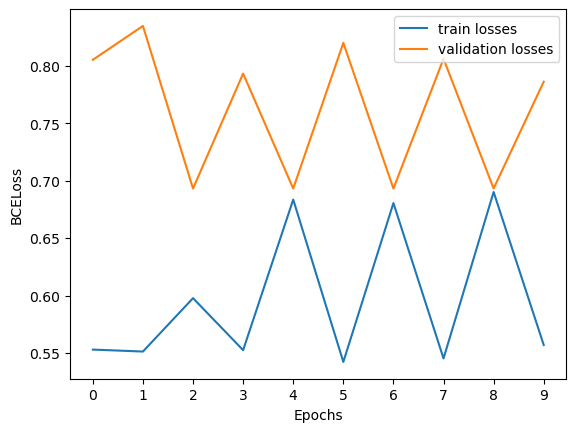

In [101]:
import matplotlib.pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.xticks([i for i in range(10)])
plt.plot([i.detach().cpu().numpy() for i in losses], label='train losses')
plt.plot([i.detach().cpu().numpy() for i in valid_losses], label='validation losses')
plt.legend()
plt.savefig('bert_10epochs_dropout_l2reg_alternate_relaxed.png')

In [102]:
with open('roberta_training_data.pkl', 'rb') as f:
    roberta_train = pickle.load(f)

In [103]:
for d in roberta_train:
    d["representation"] = torch.tensor(d["representation"], dtype=torch.float32)
    d["label"] = torch.tensor([d["label"], 1-d["label"]], dtype=torch.float32)


In [112]:
with open('roberta_validation_data.pkl', 'rb') as f:
    roberta_valid = pickle.load(f)
roberta_valid = roberta_valid[:len(roberta_valid)//2]

In [113]:
for d in roberta_valid:
    d["representation"] = torch.tensor(d["representation"], dtype=torch.float32)
    d["label"] = torch.tensor([d["label"], 1-d["label"]], dtype=torch.float32)


In [114]:
model_roberta = MLP()
learning_rate = 0.01
weight_decay = 1e-5

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [115]:
num_epochs = 10
losses = []
valid_losses = []
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_valid_loss = 0
    model_roberta.train()
    for d in roberta_train:
        # Forward pass
        outputs = model_roberta(d["representation"])
        loss = criterion(outputs, d["label"].unsqueeze(0))  # BCELoss expects a batch dimension
        
        
        l2_reg = 0
        if epoch % 2 == 0:
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
        
        total_loss = loss + 0.3*l2_reg
        
        epoch_loss += loss
        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
    epoch_loss /= len(roberta_train)
    losses.append(epoch_loss)
    
    model_roberta.eval()
    with torch.no_grad():
        for d in roberta_valid:
            valid_outputs = model_roberta(d["representation"])
            loss = criterion(valid_outputs, d['label'].unsqueeze(0))
            epoch_valid_loss += loss
    epoch_valid_loss /= len(roberta_valid)
    valid_losses.append(epoch_valid_loss)
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss.item():.4f}, Validation Loss: {epoch_valid_loss.item(): .4f}')


Epoch [1/10], Loss: 0.7113, Validation Loss:  0.7027
Epoch [2/10], Loss: 0.7106, Validation Loss:  0.7027
Epoch [3/10], Loss: 0.7110, Validation Loss:  0.7027
Epoch [4/10], Loss: 0.7088, Validation Loss:  0.7027
Epoch [5/10], Loss: 0.7085, Validation Loss:  0.7027
Epoch [6/10], Loss: 0.7116, Validation Loss:  0.7027
Epoch [7/10], Loss: 0.7132, Validation Loss:  0.7027
Epoch [8/10], Loss: 0.7107, Validation Loss:  0.7027
Epoch [9/10], Loss: 0.7079, Validation Loss:  0.7027
Epoch [10/10], Loss: 0.7112, Validation Loss:  0.7027


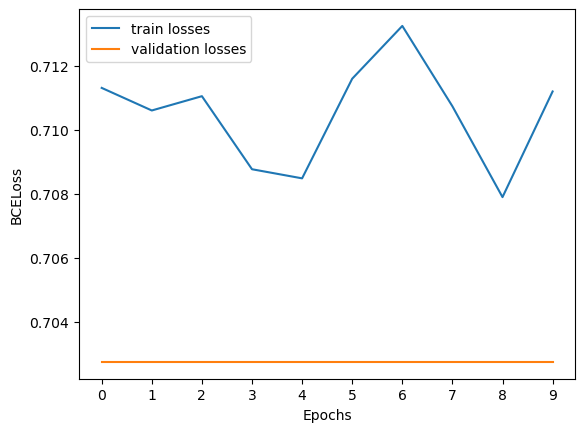

In [116]:
import matplotlib.pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.xticks([i for i in range(10)])
plt.plot([i.detach().cpu().numpy() for i in losses], label='train losses')
plt.plot([i.detach().cpu().numpy() for i in valid_losses], label='validation losses')
plt.legend()
plt.savefig('roberta_10epochs_dropout_l2reg_alternate_relaxed.png')